In [1]:
from Chemometrics.import_common import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from Chemometrics.basic import VIP, nan_ANOVA
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
b = pd.read_csv('./data/POS.csv',nrows=1)
classes = b.T.iloc[3:].reset_index(drop=True).fillna(method='ffill').loc[:,0]
a = pd.read_csv('./data/POS.csv', header=2)
feature_names = a.iloc[:,:3]
X = a.iloc[:,3:].T
X.index.name = 'SampleID'
le = LabelEncoder()
y = le.fit_transform(classes.map(str))

In [3]:
# X.to_excel('峰列表.xlsx')
# feature_names.to_excel('峰名称.xlsx')

---
## 自变量分析 - 自变量选择

In [4]:
def metrics(X, y):
    """
    计算Marker的metrics
    """
    _F, p_F = nan_ANOVA(X, y)
    plsca = PLSCanonical(n_components=1).fit(X, X.index.values)
    t1 = plsca.x_scores_[:, 0]
    vip = VIP(plsca)
    mean_ = X.groupby(y).mean()
    fc_ = fold_change(mean_.iloc[0], mean_.iloc[1])
    r1 = vcorr(t1, X.values).flatten()
    cov1_ = vcov(t1,X.values).flatten()
    metrics = pd.DataFrame({ 'ANOVA_F': _F, 
                            'ANOVA_p': p_F, 
                            'VIP': vip, 
                            'log2Fold_Change': fc_, 
                            'Corr': r1,
                           'cov': cov1_})
    return metrics

In [5]:
def  get_metrics(X, y, pair, pt=None):
    """
    变量对两两差异的贡献
    """
    _X = X.copy()
    _X.index = y
    x2 = _X.loc[pair, :]
    ms = metrics(x2, x2.index.values)
    _ms = ms
    if pt is not None:
        cond1 = ms.ANOVA_p < .01
        _ms = ms[cond1].sort_values(by='VIP', ascending=False)
    return _ms

In [6]:
%%time
mets = {}
uy = np.unique(y)
for pair in itertools.combinations(uy, 2):
    mets[pair] = get_metrics(X, y, pair, .01)

Wall time: 9.72 s


In [7]:
grp_map = pd.Series(classes.values, index=y).drop_duplicates()

In [8]:
def grp_pair(pair):
    v = grp_map.loc[list(pair)].values
    return v[0], v[1]

TypeError: <lambda>() got an unexpected keyword argument 'line'

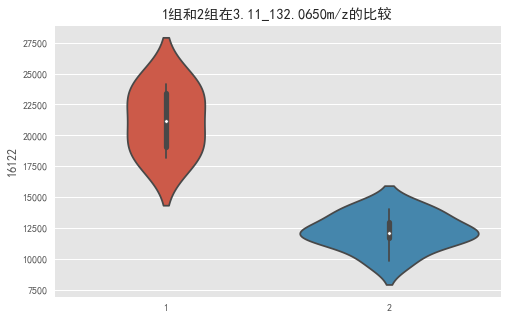

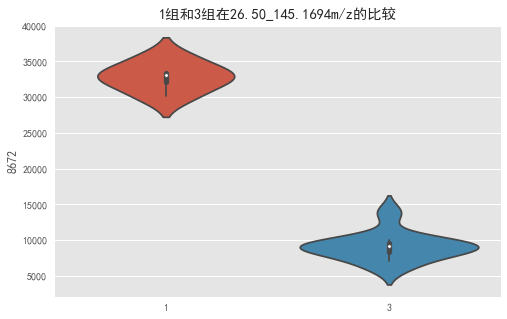

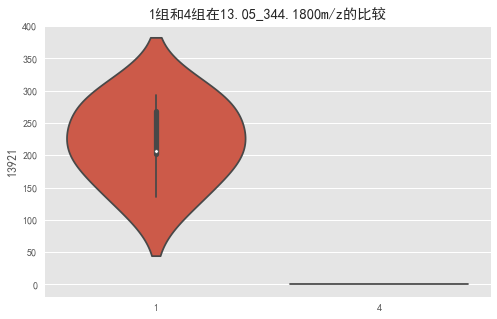

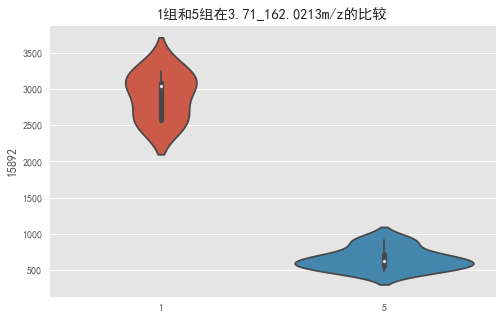

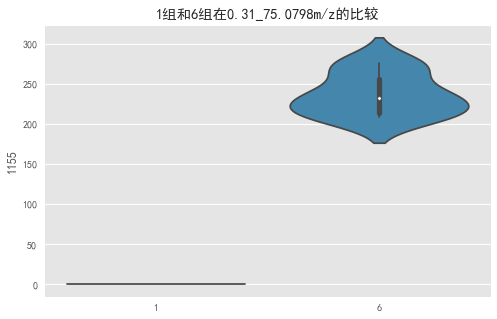

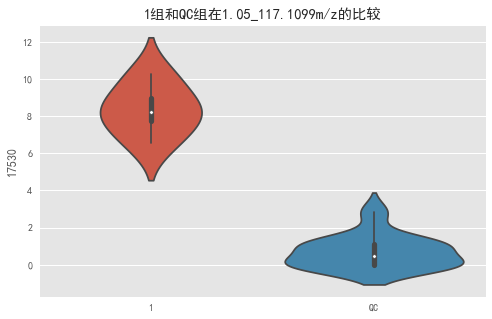

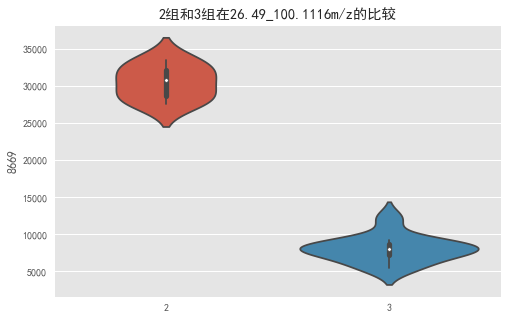

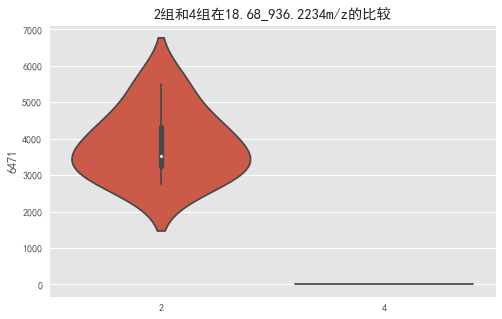

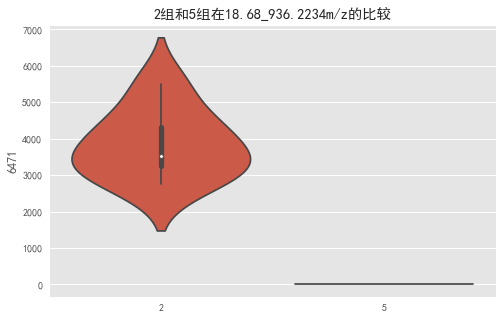

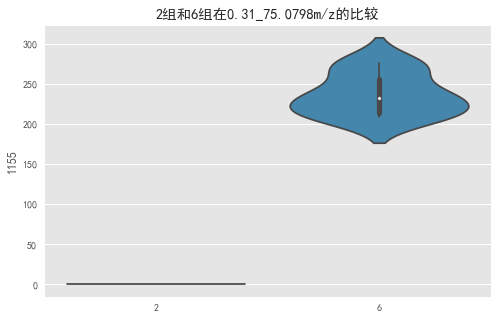

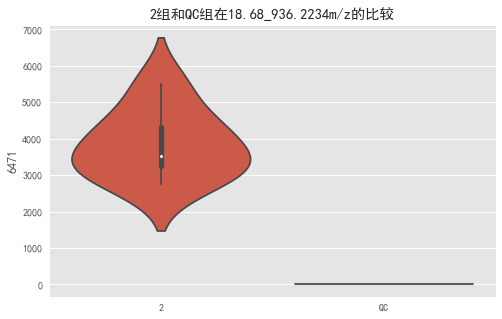

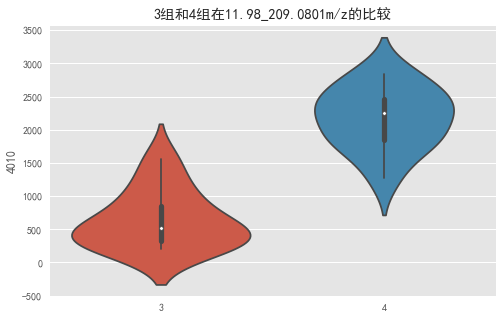

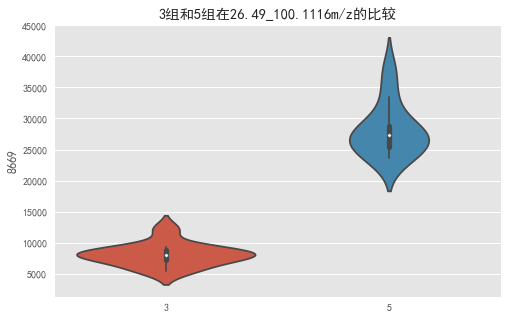

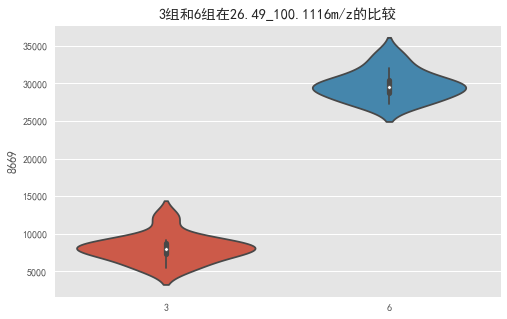

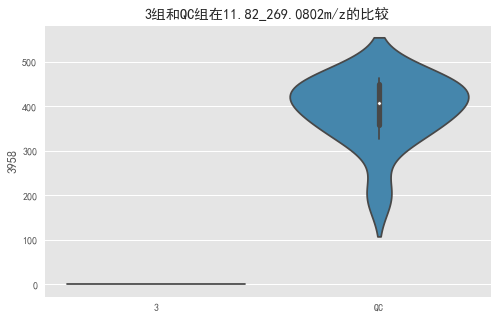

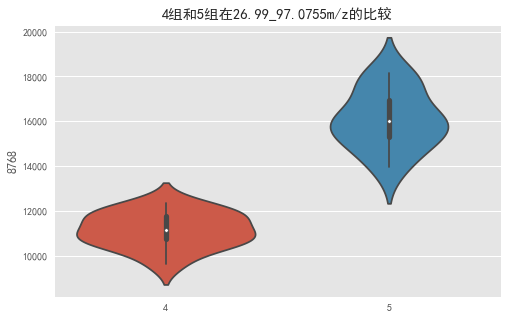

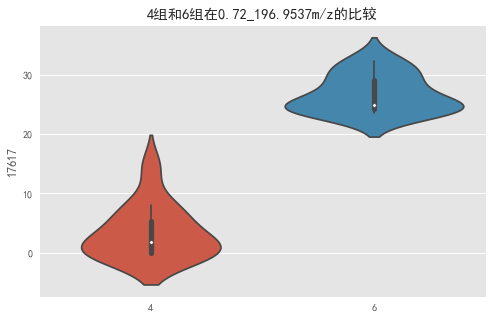

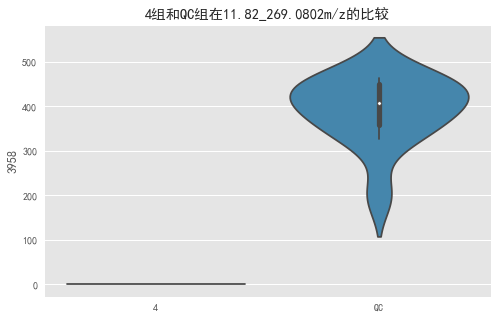

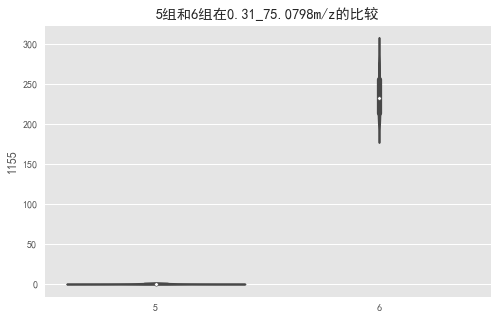

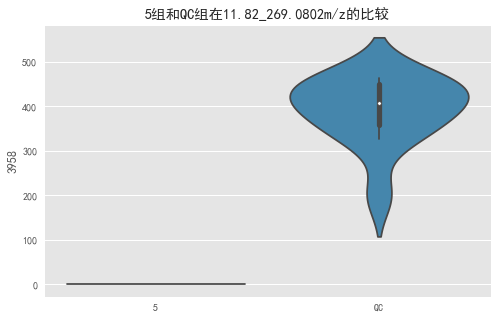

In [19]:
# 画出每个pair差异最大特征
_X = X.copy()
_X.index = y
for pair in itertools.combinations(uy, 2):
    grp1, grp2 = grp_pair(pair)
    _x = _X.loc[pair, :]
    marker_index0 = mets[pair].index[0]
    _x = _x.loc[:, marker_index0]
    plt.figure(figsize=(8,5))
    title = str(grp1) + '组和' + str(grp2) + '组在' + feature_names.Compound.loc[marker_index0]+ '的比较'
    mets[pair].to_excel(title.replace('/', '')+'.xlsx')
    plt.title(title)
    sns_plot = sns.violinplot(grp_map.loc[_x.index], _x)
    plt.savefig('./figs/'+title.replace('/', '')+'.png')

In [10]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
scores = pca.fit_transform(X)

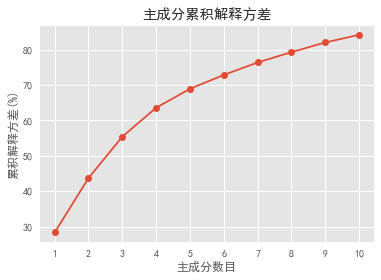

In [11]:
plt.plot(range(1,11,1), pca.explained_variance_ratio_.cumsum()[:10].round(4)*100, '-o')
plt.xticks(range(1, 11,1))
plt.xlabel('主成分数目')
plt.ylabel('累积解释方差(%)')
title = '主成分累积解释方差'
plt.title(title)
plt.savefig(title+'.png', dpi=300, bbox_inches='tight')

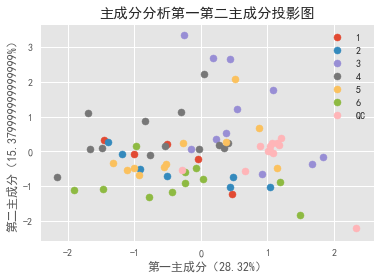

In [12]:
evr = pca.explained_variance_ratio_.round(4)
for _class in classes.unique():
    idx= classes.isin([_class])
    plt.scatter(scores[idx, 0], scores[idx, 1], label=_class)
    plt.legend()
    plt.title('主成分分析第一第二主成分投影图')
    plt.xlabel('第一主成分（{}%）'.format(evr[0]*100))
    plt.ylabel('第二主成分（{}%）'.format(evr[1]*100))
plt.savefig('主成分分析第一第二主成分投影图.png', dpi=300, bbox_inches='tight')

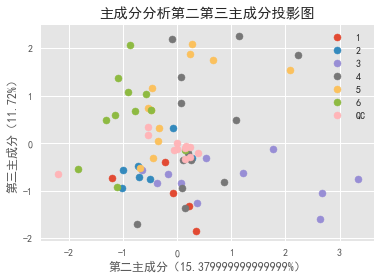

In [13]:
for _class in classes.unique():
    idx= classes.isin([_class])
    plt.scatter(scores[idx, 1], scores[idx, 2], label=_class)
    plt.legend()
    plt.title('主成分分析第二第三主成分投影图')
    plt.xlabel('第二主成分（{}%）'.format(evr[1]*100))
    plt.ylabel('第三主成分（{}%）'.format(evr[2]*100))
plt.savefig('主成分分析第二第三主成分投影图.png', dpi=300, bbox_inches='tight')

# VIP

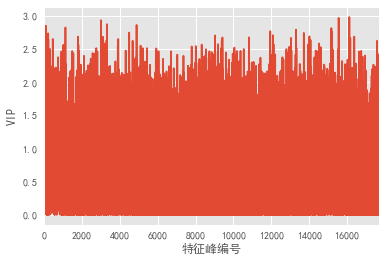

In [14]:
get_metrics(X, y, (0,1)).VIP.plot()
title = '各特征峰VIP值'
plt.xlabel('特征峰编号')
plt.ylabel('VIP')
plt.savefig(title+'.png', dpi=300, bbox_inches='tight')

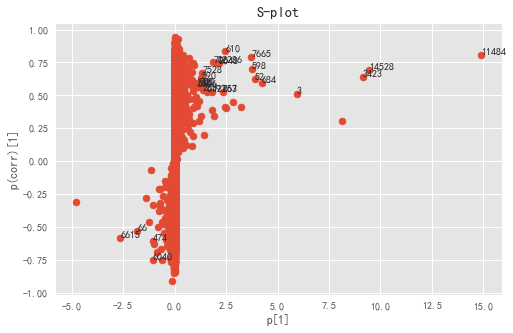

In [15]:
a = get_metrics(X, y, (0,1))
title = 'S-plot'
plt.figure(figsize=(8,5))
plt.title(title)
plt.scatter(a.loc[:, 'cov'], a.Corr)
_a = a.loc[(a.Corr.abs() > .5) & (a.loc[:,'cov'].abs() > 1)]
for idx in _a.index.values:
    plt.annotate(idx, (_a.loc[idx, 'cov'], _a.loc[idx, 'Corr']))
plt.xlabel('p[1]')
plt.ylabel('p(corr)[1]')
plt.savefig(title+'.png', dpi=300, bbox_inches='tight')

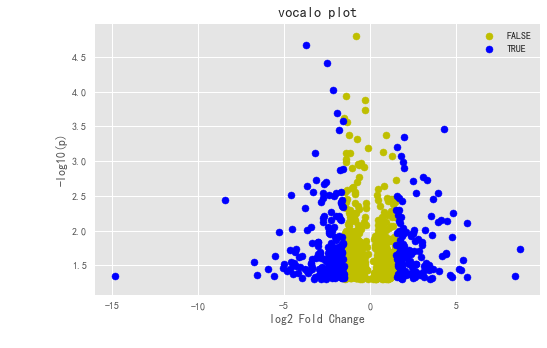

In [16]:
# V-plot
threshold_fold_change = 1.5
a_ = a.loc[a.ANOVA_p<0.05]
plt.figure(figsize=(8,5))
notdiff = a_.log2Fold_Change.abs()<threshold_fold_change
plt.scatter(a_.log2Fold_Change.loc[notdiff], -np.log10(a_.ANOVA_p.loc[notdiff]), c='y', label='FALSE')
plt.scatter(a_.log2Fold_Change.loc[~notdiff], -np.log10(a_.ANOVA_p.loc[~notdiff]), c='b', label='TRUE')
_a = a_.loc[a_.log2Fold_Change.abs() > 2]
for idx in _a.index.values:
    plt.annotate(idx, (_a.loc[idx, 'log2Fold_Change'], _a.loc[idx, 'ANOVA_p']))
plt.legend()
title= 'vocalo plot'
plt.title(title)
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p)')
plt.savefig(title+'.png', dpi=300, bbox_inches='tight')

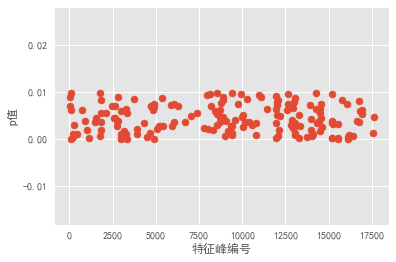

In [17]:
pv = get_metrics(X, y, (0,1)).ANOVA_p
_pv = pv[pv<.01]
plt.scatter(_pv.index, _pv)
title = '1,2组间方差分析p值'
plt.xlabel('特征峰编号')
plt.ylabel('p值')
plt.savefig(title+'.png', dpi=300, bbox_inches='tight')

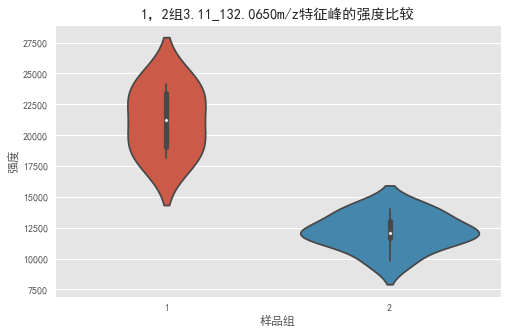

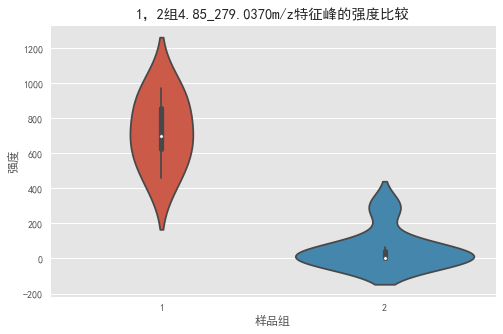

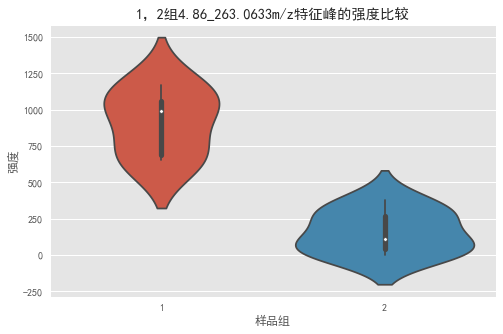

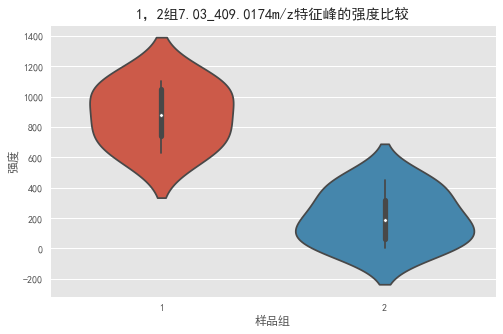

In [18]:
_X = X.copy()
_X.index = y
pair = (0,1)
grp1, grp2 = grp_pair(pair)
_m = get_metrics(X, y, pair)
_m = _m[_m.ANOVA_p<.01]
_m = _m.sort_values('VIP',ascending=False)
for i in range(4):
    marker_index0 = _m.index[i]
    _x = _X.loc[pair, marker_index0]
    plt.figure(figsize=(8,5))
    title = str(grp1) + '，' + str(grp2) + '组' + feature_names.Compound.loc[marker_index0]+ '特征峰的强度比较'
    plt.title(title)
    sns_plot = sns.violinplot(grp_map.loc[_x.index], _x)
    plt.xlabel('样品组')
    plt.ylabel('强度')
    plt.savefig(title.replace('/', '')+'.png', dpi=300)